# Regressing Litter on Deprivation in Glasgow City

This notebook performs data manipulation, exploration and analysis using count data regression models.

The objective is to determine whether one or more deprivation factors significantly increases or decreases the amount of litter in areas of Glasgow City.

## Data Preparation

- Read the data from a CSV file.
- Remove unnecessary columns.
- Assign valid data types.
- Impute missing values denoted by "*" with their mean.
- Impute missing values denoted by 0 with their mean.
- Split the data into training (70%), validation (20%) and test (10%) data sets.

In [22]:
import pandas as pd
import numpy as np

# The path to the file containing the deprivation and litter data.
data_fpath = "../data/glasgow-litter-simd2020v2.csv"

def remove_features(df):
  """Remove features from the data that we do not need"""
  columns_to_remove = [
    #"Total_population",
    #"Working_Age_population",
    "SIMD2020v2_Rank",
    "SIMD_2020v2_Percentile",
    "SIMD2020v2_Vigintile",
    "SIMD2020v2_Decile",
    "SIMD2020v2_Quintile",
    "SIMD2020v2_Income_Domain_Rank",
    "SIMD2020_Employment_Domain_Rank",
    "SIMD2020_Health_Domain_Rank",
    "SIMD2020_Education_Domain_Rank",
    "SIMD2020_Access_Domain_Rank",
    "SIMD2020_Crime_Domain_Rank",
    "SIMD2020_Housing_Domain_Rank"
  ]
  return df.drop(columns_to_remove, axis=1)

def impute_missing_data(df):
  """Replace missing values with their mean"""
  features = [
    "CIF",
    "ALCOHOL",
    "DRUG",
    "SMR",
    "DEPRESS",
    "LBWT",
    "EMERG",
    "Attendance",
    "Attainment",
    "not_participating",
    "University",
    "crime_count",
    "crime_rate",
    "broadband"
  ]
  for f in features:
    df[f].fillna(df[f].mean(), inplace=True)
    df[f].replace(to_replace=0, value=df[f].mean())
  return df

def impute_data_zones(df):
  """Impute missing values from data zone S01010206 using the zone next to it."""
  features = [
    "Total_population",
    "Working_Age_population",
    "income_rate",
    "income_count",
    "employment_rate",
    "employment_count"
  ]
  for f in features:
    dz1, dz2 = df.loc[df["Data_Zone"] == "S01010206"], df.loc[df["Data_Zone"] == "S01010207"]
    n = df.at[dz2.index[0], f]
    df.at[dz1.index[0], f] = n
  return df

def convert_float_feature_types(df):
  """Convert percentage strings to floats between 0-1"""
  to_float_features = [
    "income_rate",
    "employment_rate",
    "DEPRESS",
    "LBWT",
    "Attendance",
    "not_participating",
    "University",
    "overcrowded_rate",
    "nocentralheating_rate",
    "broadband"
  ]
  # These are not percentages
  df["crime_rate"] = df["crime_rate"].astype(float)
  df["crime_count"] = df["crime_count"].astype(float)
  df["Attainment"] = df["Attainment"].astype(float)
  for f in to_float_features:
    df[f] = df[f].str.rstrip("%").astype(float) / 100
  return df

def standardise_features(df):
  features = [
    "Total_population",
    "Working_Age_population",
    "income_rate",
    "income_count",
    "employment_rate",
    "employment_count",
    "CIF",
    "ALCOHOL",
    "DRUG",
    "SMR",
    "DEPRESS",
    "LBWT",
    "EMERG",
    "Attendance",
    "Attainment",
    "no_qualifications",
    "not_participating",
    "University",
    "drive_petrol",
    "drive_GP",
    "drive_post",
    "drive_primary",
    "drive_retail",
    "drive_secondary",
    "PT_GP",
    "PT_post",
    "PT_retail",
    "broadband",
    "crime_rate",
    "crime_count",
    "overcrowded_count",
    "overcrowded_rate",
    "nocentralheating_count",
    "nocentralheating_rate"
  ]
  sdf = df[features]
  df[features] = (sdf - sdf.mean()) / sdf.std()
  return df

def convert_categorical_feature_types(df):
  """Convert strings to categorical features"""
  to_category_features = [
    "Data_Zone",
    "Intermediate_Zone",
    "Council_area"
  ]
  for f in to_category_features:
    df[f] = df[f].astype("category")
  return df

def convert_feature_types(df):
  """Convert features to the correct types"""
  df = df.replace("*", np.NaN)
  df = convert_float_feature_types(df)
  return convert_categorical_feature_types(df)

def read_data_from_file(fpath):
  """Read the data from file, handle missing data and assign feature types"""
  df = pd.read_csv(fpath, header=0)
  df = remove_features(df)
  df = convert_feature_types(df)
  df = impute_missing_data(df)
  #df = standardise_features(df)
  return df

def split_data(df, valid_frac=0.2, test_frac=0.1, random_state=1):
  """Split into train/valid/test data (default 70%/20%/10%)"""
  train_frac = 1 - valid_frac - test_frac
  return np.split(
    df.sample(frac=1, random_state=random_state),
    [int(train_frac * len(df)), int((train_frac + valid_frac) * len(df))],
  )

def get_split_data(random_state=None):
  """Get a dataframe of the data split into train/valid/test (70%/20%/10%)"""
  df = read_data_from_file(data_fpath)
  return split_data(df, random_state=random_state)

View how many observations we have in each data set:

In [23]:
df_train, df_valid, df_test = get_split_data()

print("Training data: {} observations".format(len(df_train)))
print("Validation data: {} observations".format(len(df_valid)))
print("Test data: {} observations".format(len(df_test)))

Training data: 522 observations
Validation data: 149 observations
Test data: 75 observations


Verify that the factor data types are correct and that there are no missing values:

In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522 entries, 553 to 315
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Data_Zone               522 non-null    category
 1   Intermediate_Zone       522 non-null    category
 2   Council_area            522 non-null    category
 3   Total_population        522 non-null    int64   
 4   Working_Age_population  522 non-null    int64   
 5   income_rate             522 non-null    float64 
 6   income_count            522 non-null    int64   
 7   employment_rate         522 non-null    float64 
 8   employment_count        522 non-null    int64   
 9   CIF                     522 non-null    float64 
 10  ALCOHOL                 522 non-null    float64 
 11  DRUG                    522 non-null    float64 
 12  SMR                     522 non-null    float64 
 13  DEPRESS                 522 non-null    float64 
 14  LBWT                    

In [25]:
df_train.isnull().sum()

Data_Zone                 0
Intermediate_Zone         0
Council_area              0
Total_population          0
Working_Age_population    0
income_rate               0
income_count              0
employment_rate           0
employment_count          0
CIF                       0
ALCOHOL                   0
DRUG                      0
SMR                       0
DEPRESS                   0
LBWT                      0
EMERG                     0
Attendance                0
Attainment                0
no_qualifications         0
not_participating         0
University                0
crime_count               0
crime_rate                0
overcrowded_count         0
nocentralheating_count    0
overcrowded_rate          0
nocentralheating_rate     0
drive_petrol              0
drive_GP                  0
drive_post                0
drive_primary             0
drive_retail              0
drive_secondary           0
PT_GP                     0
PT_post                   0
PT_retail           

## Data Exploration

- Total population ranges between 288 - 2544 per data zone.
- Working age population ranges between 165 - 2361 per data zone.
- On average, 19% are income deprived.
- On average, 13% are employment deprived.
- On average, 21% are prescribed drugs for anxiety, depression or psychosis.
- On average, 6% of births are live singleton or low weight.
- On average, there is a 76% pupil attendance at school.
- On average, the attainment score of school leavers is 5.4.
- On average, 4% of 16 - 19 year olds are not in education, employment or training.
- On average, 8% of 17 - 21 year olds are entering university.
- On average, the comparative illness factor ratio is 148 (100 is Scottish average.)
- On average, the standardised mortality ratio is 123 (100 is Scottish average.)
- On average, the hospital stays related to alcohol misuse ratio is 170 (100 is Scottish average.)
- On average, the hospital stays related to drug misuse ratio is 155 (100 is Scottish average.)
- On average, the emergency hospital stays ratio is 118 (100 is Scottish average.)
- On average, the working age population with no qualifications ratio is 151 (100 is Scottish average.)
- On average, it's a 3.1 minute drive to a petrol station.
- On average, it's a 2.3 minute drive to a GP.
- On average, it's a 7 minute journey to a GP via public transport.
- On average, it's a 2.3 minute drive to a post office.
- On average, it's a 7 minute journey to a post office via public transport.
- On average, it's a 2.6 minute drive to a primary school.
- On average, it's a 4.2 minute drive to a secondary school.
- On average, it's a 3.4 minute drive to a retail centre.
- On average, it's a 9.5 minute journey to a retail centre via public transport.
- On average, 1% of premises do not have access to superfast broadband.
- On average, there are 446 incidents of crime per 10,000 people.
- On average, 21% are in overcrowded households.
- On average, 3% are in households without central heating.
- Litter ranges between 9 - 179 per data zone.
- On average, there are 61 littered objects per data zone.

In [26]:
df_train.describe()

,Total_population,Working_Age_population,income_rate,income_count,employment_rate,employment_count,CIF,ALCOHOL,DRUG,SMR,...,drive_GP,drive_post,drive_primary,drive_retail,drive_secondary,PT_GP,PT_post,PT_retail,broadband,litter
count,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,...,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000
mean,834.890805,589.559387,0.200651,163.613027,0.145402,80.471264,153.960979,181.452952,163.735972,123.452360,...,2.371702,2.361255,2.616841,3.528327,4.266979,7.174184,7.106026,9.663221,0.016707,61.881226
std,249.008401,222.223896,0.122864,106.274694,0.092342,53.267083,72.341289,147.142720,173.174091,60.631056,...,1.031543,0.839660,0.892099,1.332792,1.350307,3.037846,2.527443,3.403724,0.053043,29.164522
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,6.000000,0.000000,19.000000,...,0.664751,0.667906,0.979924,0.843476,1.290801,1.595565,1.831674,2.289857,0.000000,9.000000
25%,688.000000,451.000000,0.090000,71.250000,0.060000,35.000000,90.000000,79.000000,41.000000,88.000000,...,1.612534,1.733119,1.961328,2.614207,3.269634,5.068204,5.386374,7.286510,0.000000,41.000000
50%,809.000000,552.500000,0.200000,153.000000,0.140000,71.500000,160.000000,156.500000,122.000000,116.000000,...,2.167734,2.242858,2.498595,3.394585,4.150823,6.793189,6.781696,9.246430,0.000000,57.000000
75%,939.750000,673.750000,0.300000,240.750000,0.220000,117.000000,210.000000,245.500000,230.750000,147.000000,...,2.994385,2.907171,3.098841,4.347410,5.112141,8.968366,8.592439,11.621552,0.000000,78.000000
max,2429.000000,2342.000000,0.490000,656.000000,0.470000,311.000000,310.000000,1656.000000,1575.000000,824.000000,...,6.555288,5.201232,5.510370,8.521768,8.467000,21.908923,16.288734,23.645457,0.460000,179.000000


In [27]:
df_train.head()

,Data_Zone,Intermediate_Zone,Council_area,Total_population,Working_Age_population,income_rate,income_count,employment_rate,employment_count,CIF,...,drive_GP,drive_post,drive_primary,drive_retail,drive_secondary,PT_GP,PT_post,PT_retail,broadband,litter
553,S01010311,Keppochhill,Glasgow City,812,572,0.35,288,0.24,136,245.0,...,1.022153,1.551540,2.777734,1.541595,6.535038,3.602968,3.646768,3.889320,0.02,117
97,S01009855,Mosspark,Glasgow City,594,398,0.11,64,0.11,45,150.0,...,3.571276,3.476565,1.402008,5.771709,6.472279,10.402998,10.159917,18.733549,0.00,37
462,S01010220,Cowlairs and Port Dundas,Glasgow City,529,485,0.03,16,0.02,9,30.0,...,3.001213,3.664470,3.352303,3.856854,6.134500,7.033834,7.593540,7.916218,0.00,114
358,S01010116,"Garthamlock, Auchinlea and Gartloch",Glasgow City,1182,842,0.09,112,0.08,66,120.0,...,2.944922,2.027598,2.839186,3.808064,6.630054,8.947299,8.116848,8.049078,0.00,24
20,S01009778,Nitshill,Glasgow City,809,466,0.36,288,0.25,115,230.0,...,2.973902,1.661676,1.930307,3.188780,5.796930,9.791092,5.210931,10.881469,0.00,102


### Correlations

The positive correlations are income_rate, no_qualifications, employment_rate, CIF, income_count, EMERG, ALCOHOL, DEPRESS, overcrowded_rate, DRUG and SMR.

The negative correlations are Attendance, Attainment and University.

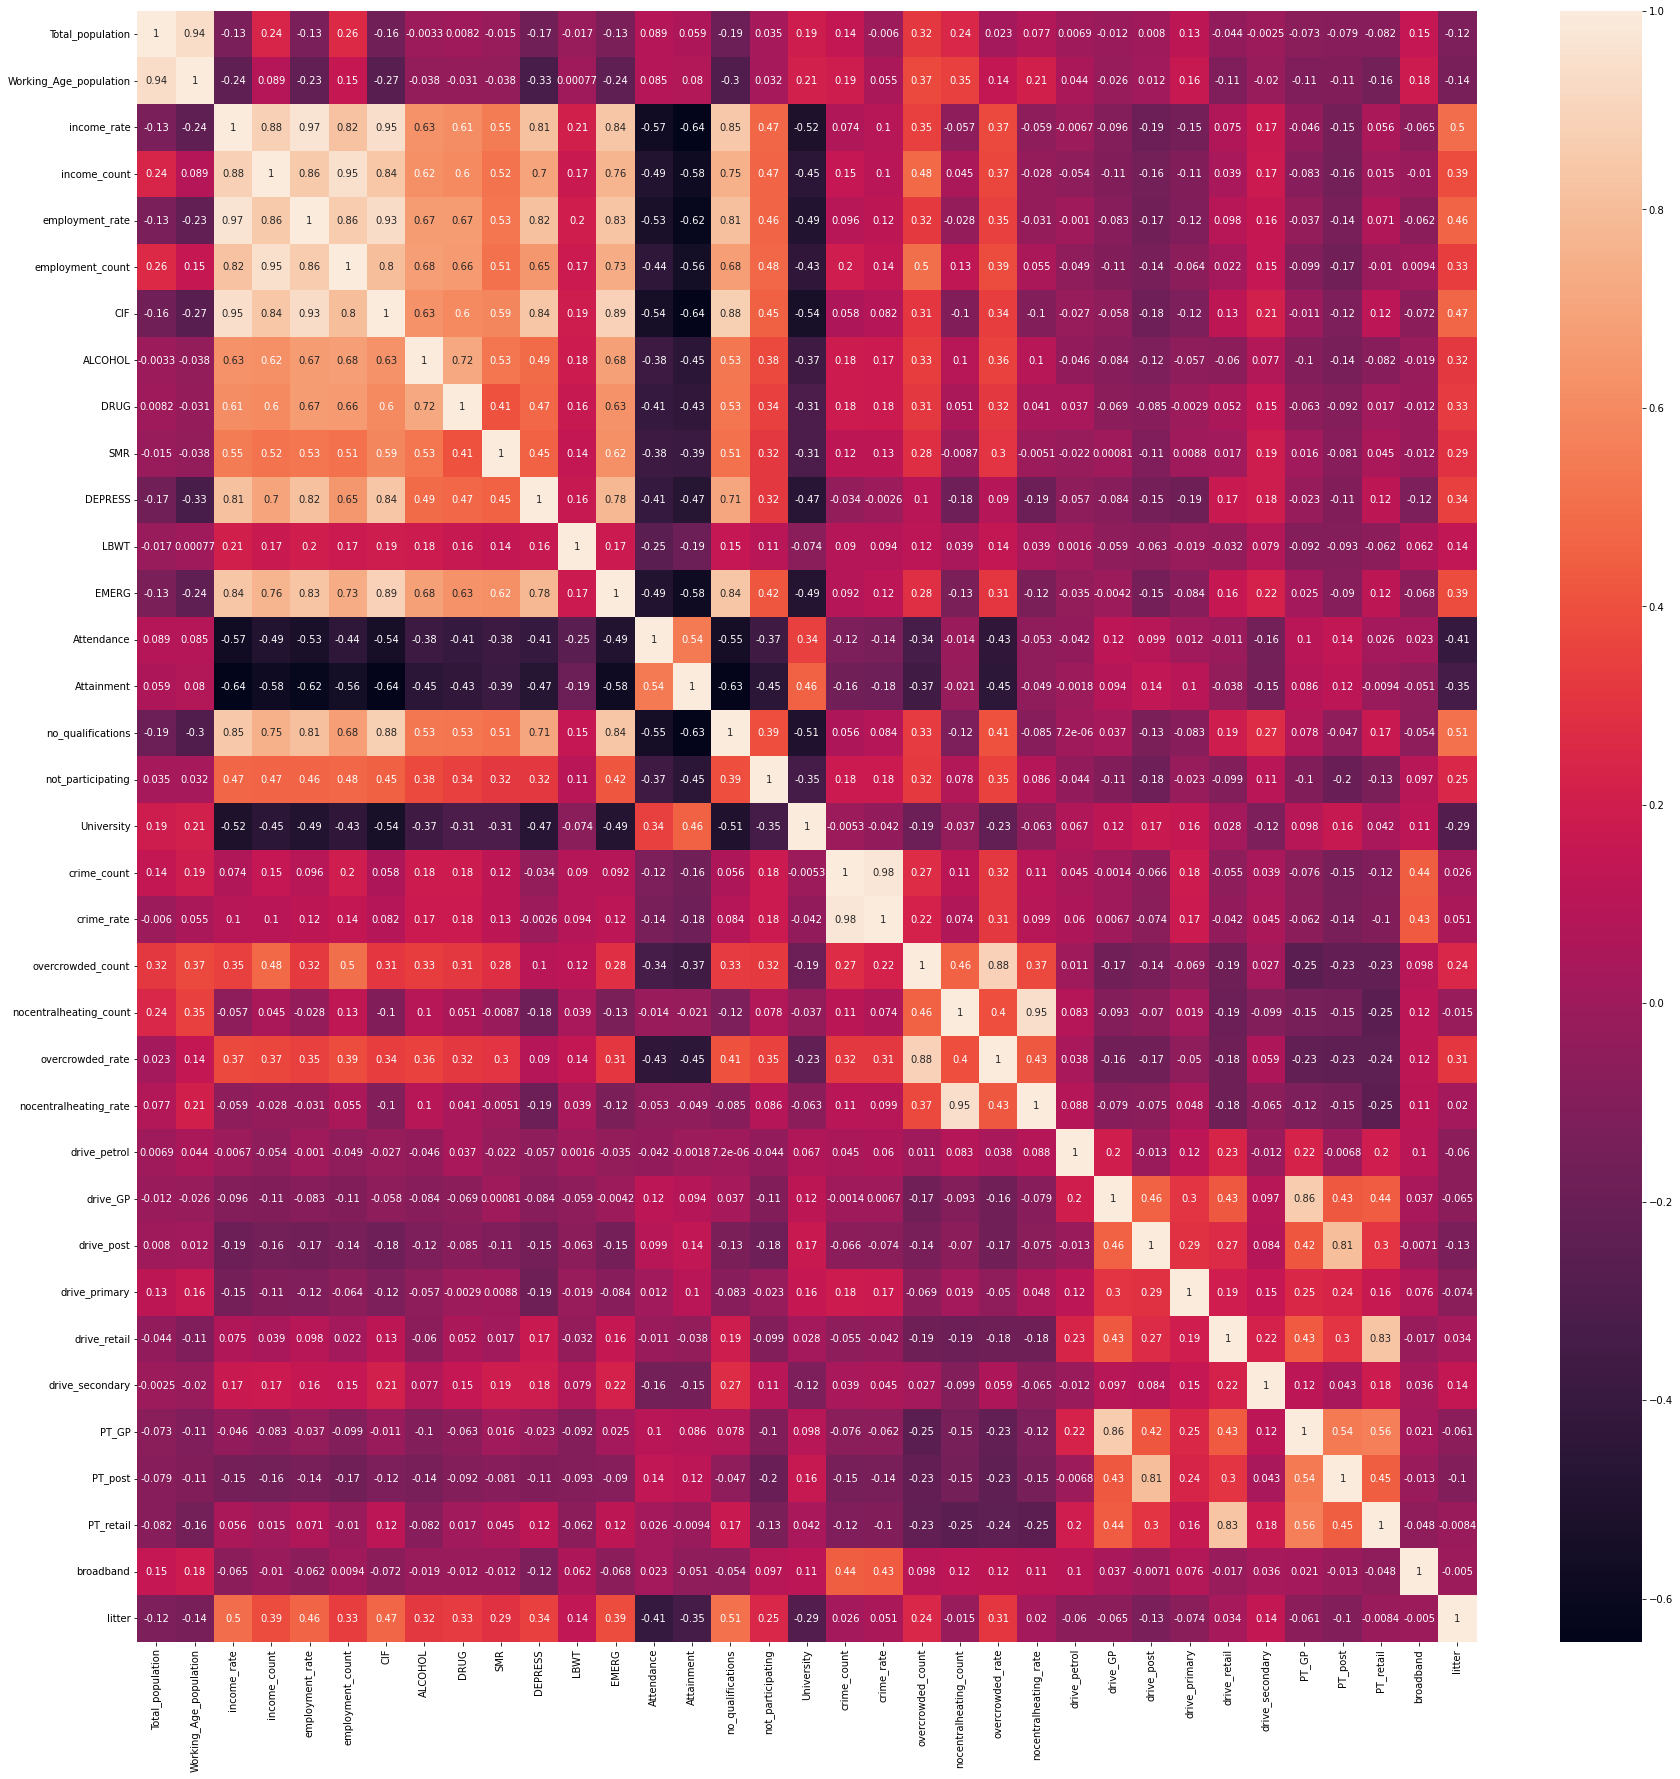

In [28]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_correlation_matrix(df, columns, figsize=(10,10)):
  plt.figure(figsize=figsize)
  corr_df = pd.DataFrame(df, columns=columns)
  sn.heatmap(corr_df.corr(), annot=True)
  plt.show()

plot_correlation_matrix(df_train, df_train.columns, figsize=(30,30))

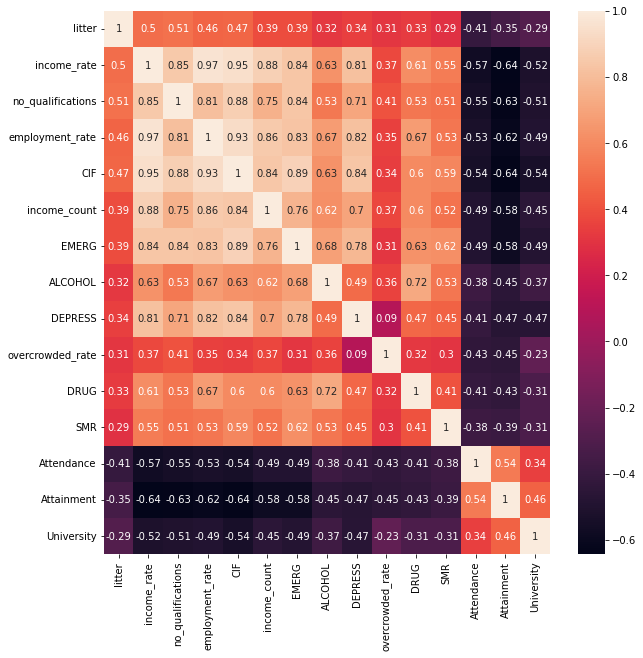

In [29]:
features_with_corr = [
  "litter",
  "income_rate",
  "no_qualifications",
  "employment_rate",
  "CIF",
  "income_count",
  "EMERG",
  "ALCOHOL",
  "DEPRESS",
  "overcrowded_rate",
  "DRUG",
  "SMR",
  "Attendance",
  "Attainment",
  "University"
]

plot_correlation_matrix(df_train, columns=features_with_corr)

## Visualise

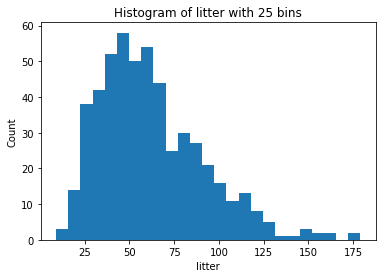

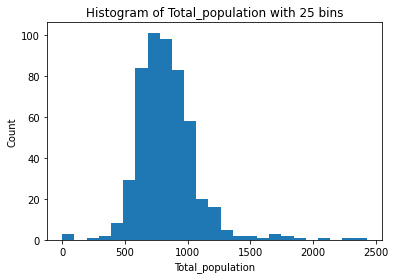

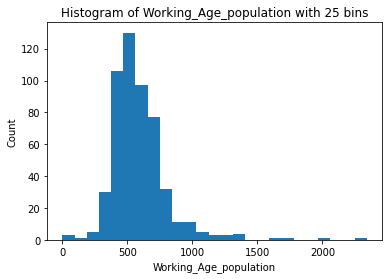

In [30]:
def plot_histogram(column, bins=25):
  ax = df_train.hist(column=column, bins=bins, grid=False)
  for x in ax[0]:
    x.set_title(f"Histogram of {column} with {bins} bins")
    x.set_xlabel(column)
    x.set_ylabel("Count")

plot_histogram("litter")
plot_histogram("Total_population")
plot_histogram("Working_Age_population")

## Standardise

Standardise the predictors for regression as they are in different units.

In [31]:
df_train = standardise_features(df_train)
df_valid = standardise_features(df_valid)
df_test = standardise_features(df_test)

## Poission

Train a Poisson regression model using forward variable selection.

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

def forward_selection(df, response, smf_model=smf.poisson, family=sm.families.Poisson()):
    remaining = set(df.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(selected + [candidate]))
            model = smf_model(formula, df).fit(method="newton")
            score = model.aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        print(f"current_score ({current_score}) > best_new_score ({best_new_score})")
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print("Best new score:", best_new_score)
            print("Selected:", selected)
            print("Remaining:", remaining)
            print()
    print("Best score:", best_new_score)
    print("Selected:", selected)
    print("Remaining:", remaining)
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    print("CHOSEN FORMULA: ", formula)
    y_train, X_train = dmatrices(formula, df, return_type="dataframe")
    model = sm.GLM(y_train, X_train, family=family).fit()
    return model

#df_train_in = df_train.drop(["Data_Zone", "Intermediate_Zone", "Council_area"], axis=1)
df_train_in = df_train[features_with_corr]
poisson_model = forward_selection(df_train_in, "litter")

Optimization terminated successfully.
         Current function value: 8.638590
         Iterations 4
Optimization terminated successfully.
         Current function value: 8.433111
         Iterations 5
Optimization terminated successfully.
         Current function value: 8.642325
         Iterations 4
Optimization terminated successfully.
         Current function value: 7.929823
         Iterations 5
Optimization terminated successfully.
         Current function value: 8.848645
         Iterations 5
Optimization terminated successfully.
         Current function value: 8.805133
         Iterations 5
Optimization terminated successfully.
         Current function value: 8.469210
         Iterations 5
Optimization terminated successfully.
         Current function value: 8.968981
         Iterations 5
Optimization terminated successfully.
         Current function value: 8.797945
         Iterations 5
Optimization terminated successfully.
         Current function value: 8.816008
  

In [33]:
print(poisson_model.summary())
print("AIC:", poisson_model.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                  522
Model:                            GLM   Df Residuals:                      507
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3763.6
Date:                Sat, 19 Feb 2022   Deviance:                       4470.3
Time:                        16:32:39   Pearson chi2:                 4.56e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9887
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.0892      0.00

The model does not fit as its pearson chi squared value is greater than expected.

In [34]:
from scipy.stats import chi2

def check_pearson_chi2(pearson_chi2, residuals):
  chi_sq = chi2.ppf(.05, df=residuals)
  print("Pearson Chi Sq <= Chi Sq")
  print(f"{pearson_chi2} <= {chi_sq}")
  print(f"The model fits: {pearson_chi2 <= chi_sq}")

check_pearson_chi2(pearson_chi2=poisson_model.pearson_chi2, residuals=poisson_model.df_resid)

Pearson Chi Sq <= Chi Sq
4558.164975220248 <= 455.7837496391018
The model fits: False


## Negative Binomial

Train a negative binomial regression model using forward variable selection.

In [35]:
nb_model = forward_selection(df_train_in, "litter", smf_model=smf.negativebinomial, family=sm.families.NegativeBinomial(alpha=0.2))

Optimization terminated successfully.
         Current function value: 4.635154
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.609845
         Iterations 4
Optimization terminated successfully.
         Current function value: 4.625921
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.565722
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.641646
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.636348
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.608576
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.650507
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.653882
         Iterations 6
Optimization terminated successfully.
         Current function value: 4.638783
  

The model does fit.

In [36]:
print(nb_model.summary())
print("AIC:", nb_model.aic)
check_pearson_chi2(pearson_chi2=nb_model.pearson_chi2, residuals=nb_model.df_resid)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                  522
Model:                            GLM   Df Residuals:                      507
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2363.6
Date:                Sat, 19 Feb 2022   Deviance:                       349.11
Time:                        16:32:40   Pearson chi2:                     345.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2895
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.0882      0.02

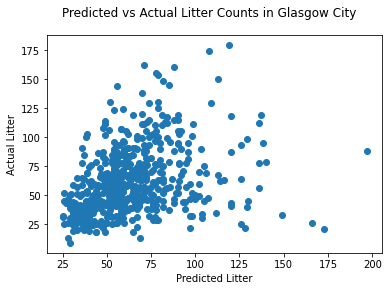

In [37]:
import matplotlib.pyplot as plt

def get_predicted_counts(model, X):
    predictions = model.get_prediction(X)
    df_predictions = predictions.summary_frame()
    return round(df_predictions["mean"])

def scatter_plot(df, formula, model):
    y, X = dmatrices(formula, df, return_type="dataframe")
    predicted_counts, actual_counts = get_predicted_counts(model, X), y["litter"]
    fig = plt.figure()
    fig.suptitle("Predicted vs Actual Litter Counts in Glasgow City")
    plt.scatter(x=predicted_counts, y=actual_counts)
    plt.xlabel("Predicted Litter")
    plt.ylabel("Actual Litter")
    plt.show()

nb_model_formula = "litter ~ SMR + DRUG + ALCOHOL + DEPRESS + EMERG + Attainment + University + income_count + employment_rate + CIF + no_qualifications + Attendance + overcrowded_rate + income_rate"
scatter_plot(df_train_in, nb_model_formula, nb_model)

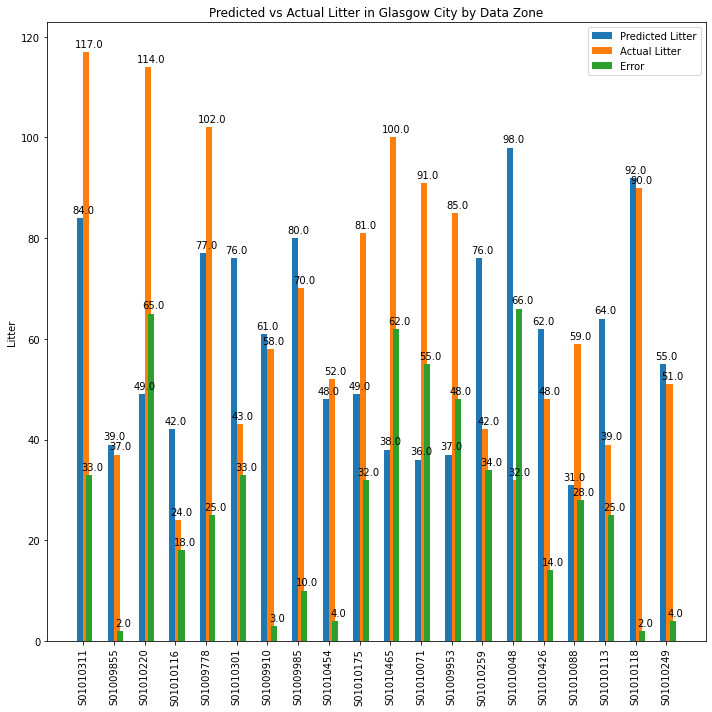

In [38]:
def bar_plot(df, formula, model, n_bars=20, bar_width=0.2):
    y, X = dmatrices(formula, df, return_type="dataframe")
    indices = X.index[:n_bars]
    labels = read_data_from_file(data_fpath).iloc[indices]["Data_Zone"]
    predicted_counts, actual_counts = get_predicted_counts(model, X), y["litter"]
    y_predicted = predicted_counts[:n_bars]
    y_actual = actual_counts[:n_bars]
    y_err = abs(y_predicted - y_actual)

    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    x = np.arange(len(labels))
    rects1 = ax.bar(x - bar_width/2, y_predicted, bar_width, label="Predicted Litter")
    rects2 = ax.bar(x + bar_width/2, y_actual, bar_width, label="Actual Litter")
    rects3 = ax.bar(x + (bar_width/2) + (bar_width/2), y_err, bar_width, label="Error")
    ax.set_ylabel("Litter")
    ax.set_title("Predicted vs Actual Litter in Glasgow City by Data Zone")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.legend()
    for rects in [rects1, rects2, rects3]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f"{height}",
                xy=(rect.get_x() + rect.get_width() / 2 + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center", va='bottom'
        )
    fig.tight_layout()
    plt.show()

bar_plot(df_train_in, nb_model_formula, nb_model)

### Validation

Use the validation data set this time.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                  149
Model:                            GLM   Df Residuals:                      134
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -673.01
Date:                Sat, 19 Feb 2022   Deviance:                       93.627
Time:                        16:32:40   Pearson chi2:                     96.8
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2148
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.0938      0.03

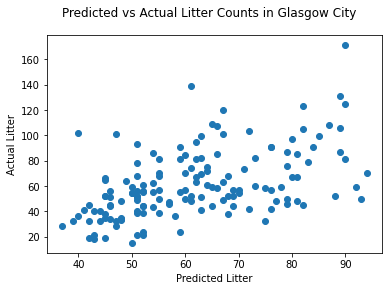

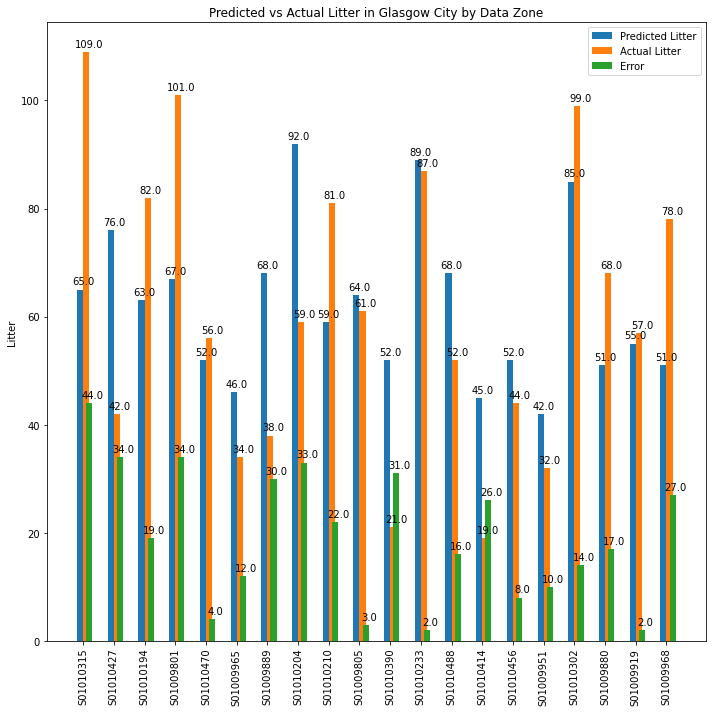

In [39]:
y_valid, X_valid = dmatrices(nb_model_formula, df_valid, return_type="dataframe")
nb_model_valid = sm.GLM(y_valid, X_valid, family=sm.families.NegativeBinomial(alpha=0.2)).fit()
print(nb_model_valid.summary())
print("AIC:", nb_model_valid.aic)
check_pearson_chi2(pearson_chi2=nb_model_valid.pearson_chi2, residuals=nb_model_valid.df_resid)
scatter_plot(df_valid, nb_model_formula, nb_model_valid)
bar_plot(df_valid, nb_model_formula, nb_model_valid)

### Bonferroni Correction

Apply Bonferroni correction to the p-values to account for significant by random chance.

In [40]:
from statsmodels.stats.multitest import multipletests
reject, corrected_pvalues, _, _ = multipletests(nb_model_valid.pvalues, alpha=0.05, method="bonferroni")
print(nb_model_valid.pvalues)
print(corrected_pvalues)
print(reject)

Intercept            0.000000
SMR                  0.868918
DRUG                 0.402139
ALCOHOL              0.548350
DEPRESS              0.875359
EMERG                0.887347
Attainment           0.852116
University           0.920962
income_count         0.963968
employment_rate      0.966785
CIF                  0.690976
no_qualifications    0.174381
Attendance           0.551835
overcrowded_rate     0.248224
income_rate          0.408911
dtype: float64
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ True False False False False False False False False False False False
 False False False]


### Test

Apply to the test data set.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                   75
Model:                            GLM   Df Residuals:                       60
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -326.25
Date:                Sat, 19 Feb 2022   Deviance:                       36.023
Time:                        16:32:41   Pearson chi2:                     36.3
No. Iterations:                     8   Pseudo R-squ. (CS):             0.2412
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.9813      0.05

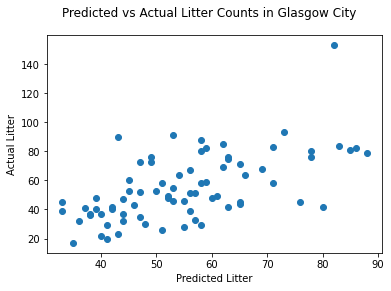

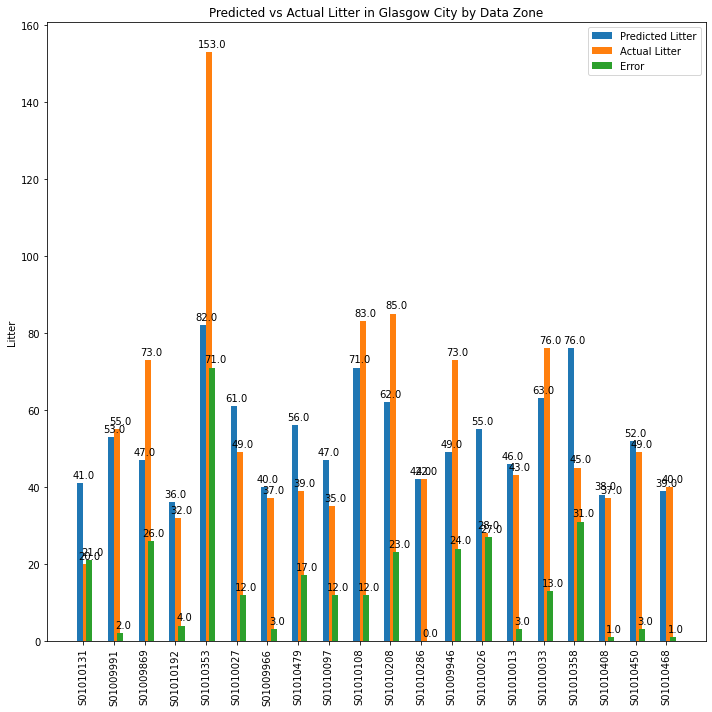

In [41]:
y_test, X_test = dmatrices(nb_model_formula, df_test, return_type="dataframe")
nb_model_test = sm.GLM(y_test, X_test, family=sm.families.NegativeBinomial(alpha=0.2)).fit()
print(nb_model_test.summary())
print("AIC:", nb_model_test.aic)
check_pearson_chi2(pearson_chi2=nb_model_test.pearson_chi2, residuals=nb_model_test.df_resid)
scatter_plot(df_test, nb_model_formula, nb_model_test)
bar_plot(df_test, nb_model_formula, nb_model_test)

In [42]:
reject, corrected_pvalues, _, _ = multipletests(nb_model_test.pvalues, alpha=0.05, method="bonferroni")
print(nb_model_test.pvalues)
print(corrected_pvalues)
print(reject)

Intercept            0.000000
SMR                  0.549853
DRUG                 0.259081
ALCOHOL              0.264197
DEPRESS              0.979500
EMERG                0.937016
Attainment           0.682149
University           0.578914
income_count         0.990731
employment_rate      0.855440
CIF                  0.491894
no_qualifications    0.954448
Attendance           0.729645
overcrowded_rate     0.517710
income_rate          0.642600
dtype: float64
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ True False False False False False False False False False False False
 False False False]
